In [41]:
from dataset.utils import pNormalize, classCount
from dataset.datasets import sentinel
from model.models import UNET
from torch.utils.data import DataLoader
from train.metrics import computeConfMats, computeClassMetrics, wma, printClassMetrics, printModelMetrics, plotConfusionMatrices, plotConfusionMatrix
import torch

q_hi = torch.tensor([2102.0, 1716.0, 1398.0, 4732.0, 2434.42919921875, 3701.759765625, 4519.2177734375, 4857.7734375, 3799.80322265625, 3008.8935546875])
q_lo = torch.tensor([102.0, 159.0, 107.0, 77.0, 106.98081970214844, 79.00384521484375, 86.18966674804688, 70.40167236328125, 50.571197509765625, 36.95356750488281])    
norm = pNormalize(maxPer=q_hi,minPer=q_lo)

# Hyperparams
BATCH_SIZE = 4
NUM_WORKERS = 0

# Create experimental dataset, rgb=True for 3 channels (default = False)
# POINT TO FOLDER WITH TIMEPERIOD(S) WITH SUBFOLDERS: 'test, 'train, 'val
test_set = sentinel(root_dir='processed-data/dsen_2_256_new_split/', img_transform=norm,data="val",timeperiod=1)

# Pass in the dataset into DataLoader to create an iterable over the dataset
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Define model
dataiter = iter(test_loader)
images, labels = dataiter.next()
model = UNET(in_channels=images.shape[1],classes=28)
model.load_state_dict(torch.load('runs/WCE_FTL_100_epochs_all_bands_TP1_20220610_1233/saved_model/model_epoch_71.pt',map_location=torch.device('cuda'))) # Pass in 'trained_model.pt' and load model

# 1 EPOCH TESTING
dataiter = iter(test_loader) # Create an object which can be iterated one element at a time
model.eval() # TOGGLE ON EVALUATION MODE
with torch.no_grad():
     # n_class - unclassified class, i.e. 28-1 = 27
     cMats = torch.zeros((27,2,2),dtype=torch.int32)
     class_metrics = torch.zeros((27,6),dtype=torch.float32)
     
     model_metrics = torch.zeros(6,dtype=torch.float32)
         
     predarr = torch.tensor([],dtype=torch.int32)
     labelarr = torch.tensor([],dtype=torch.int32)
     
     for images, labels in dataiter:
          outputs = model(images)
          preds = torch.nn.functional.softmax(outputs,dim=1)
          preds = torch.argmax(preds,dim=1)
          cMats += computeConfMats(labels,preds)
          
          # Flatten dimensions BxHxW --> B*H*W and concatenate
          predarr = torch.cat((predarr, preds.reshape(-1)))
          labelarr = torch.cat((labelarr, labels.reshape(-1)))
#model.train() # TOGGLE ON TRAIN MODE WHEN EVALUATION IS DONE

In [32]:
# Get class counts for dataset
classCounts,_ = classCount(test_loader)

In [42]:
# Compute class and model metrics
class_metrics = computeClassMetrics(cMats)
model_metrics = wma(class_metrics,classCounts)

/home/exjobbare/projects/datadrive0/deepSat/train/metrics.py:133: UserWarning: Precision: Division by zero. Metric is undefined and set to 0
  metric = 0.0
/home/exjobbare/projects/datadrive0/deepSat/train/metrics.py:179: UserWarning: MCC: Division by zero. Metric is undefined and set to 0
  metric = 0.0
/home/exjobbare/projects/datadrive0/deepSat/train/metrics.py:144: UserWarning: Recall: Division by zero. Metric is undefined and set to 0
  metric = 0.0
/home/exjobbare/projects/datadrive0/deepSat/train/metrics.py:155: UserWarning: F1-Score: Division by zero. Metric is undefined and set to 0
  metric = 0.0
/home/exjobbare/projects/datadrive0/deepSat/train/metrics.py:166: UserWarning: IoU: Division by zero. Metric is undefined and set to 0
  metric = 0.0


In [43]:
# Print model metrics
printModelMetrics(model_metrics)

@@ Weighted Macro-Average Model Metrics @@

Accuracy                           : 0.9296
Precision                          : 0.7665
Recall                             : 0.7428
F1-Score                           : 0.7484
Intersection over Union            : 0.6290
Matthews Correlation Coefficient   : 0.7019


In [44]:
# Print class Metrics
printClassMetrics(class_metrics,classCounts)

@@ Class Metrics @@

Label    UA2018 ID       % Data     Accuracy   Precision  Recall     F1-Score   IoU        MCC        Description
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1        11100           0.05       0.9994     0.3387     0.5052     0.4055     0.2543     0.4134     Continuous Urban Fabric
2        11210           0.34       0.9965     0.4564     0.4520     0.4542     0.2938     0.4524     Discontinuous Dense Urban Fabric
3        11220           1.21       0.9916     0.5072     0.3822     0.4359     0.2787     0.4362     Discontinuous Medium Density Urban Fabric
4        11230           2.75       0.9728     0.4611     0.5454     0.4997     0.3331     0.4876     Discontinuous Low Density Urban Fabric
5        11240           2.84       0.9754     0.5716     0.4333     0.4929     0.3271     0.4854     Discontinuous Very Low Density U

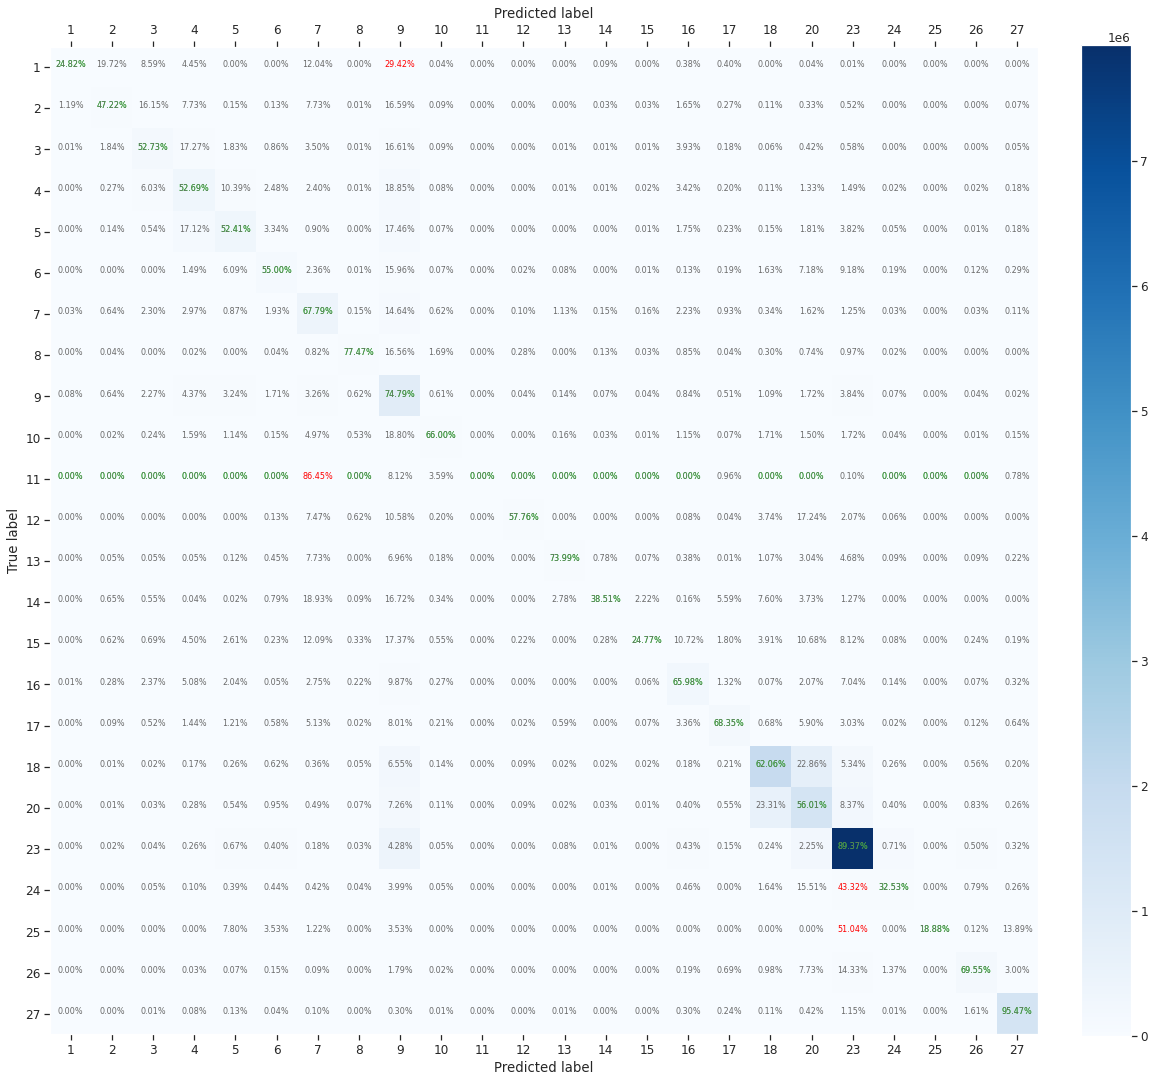

In [36]:
# Plot N_CLASS X N_CLASS confusion matrix
plotConfusionMatrix(yTrue=labelarr,yPred=predarr)

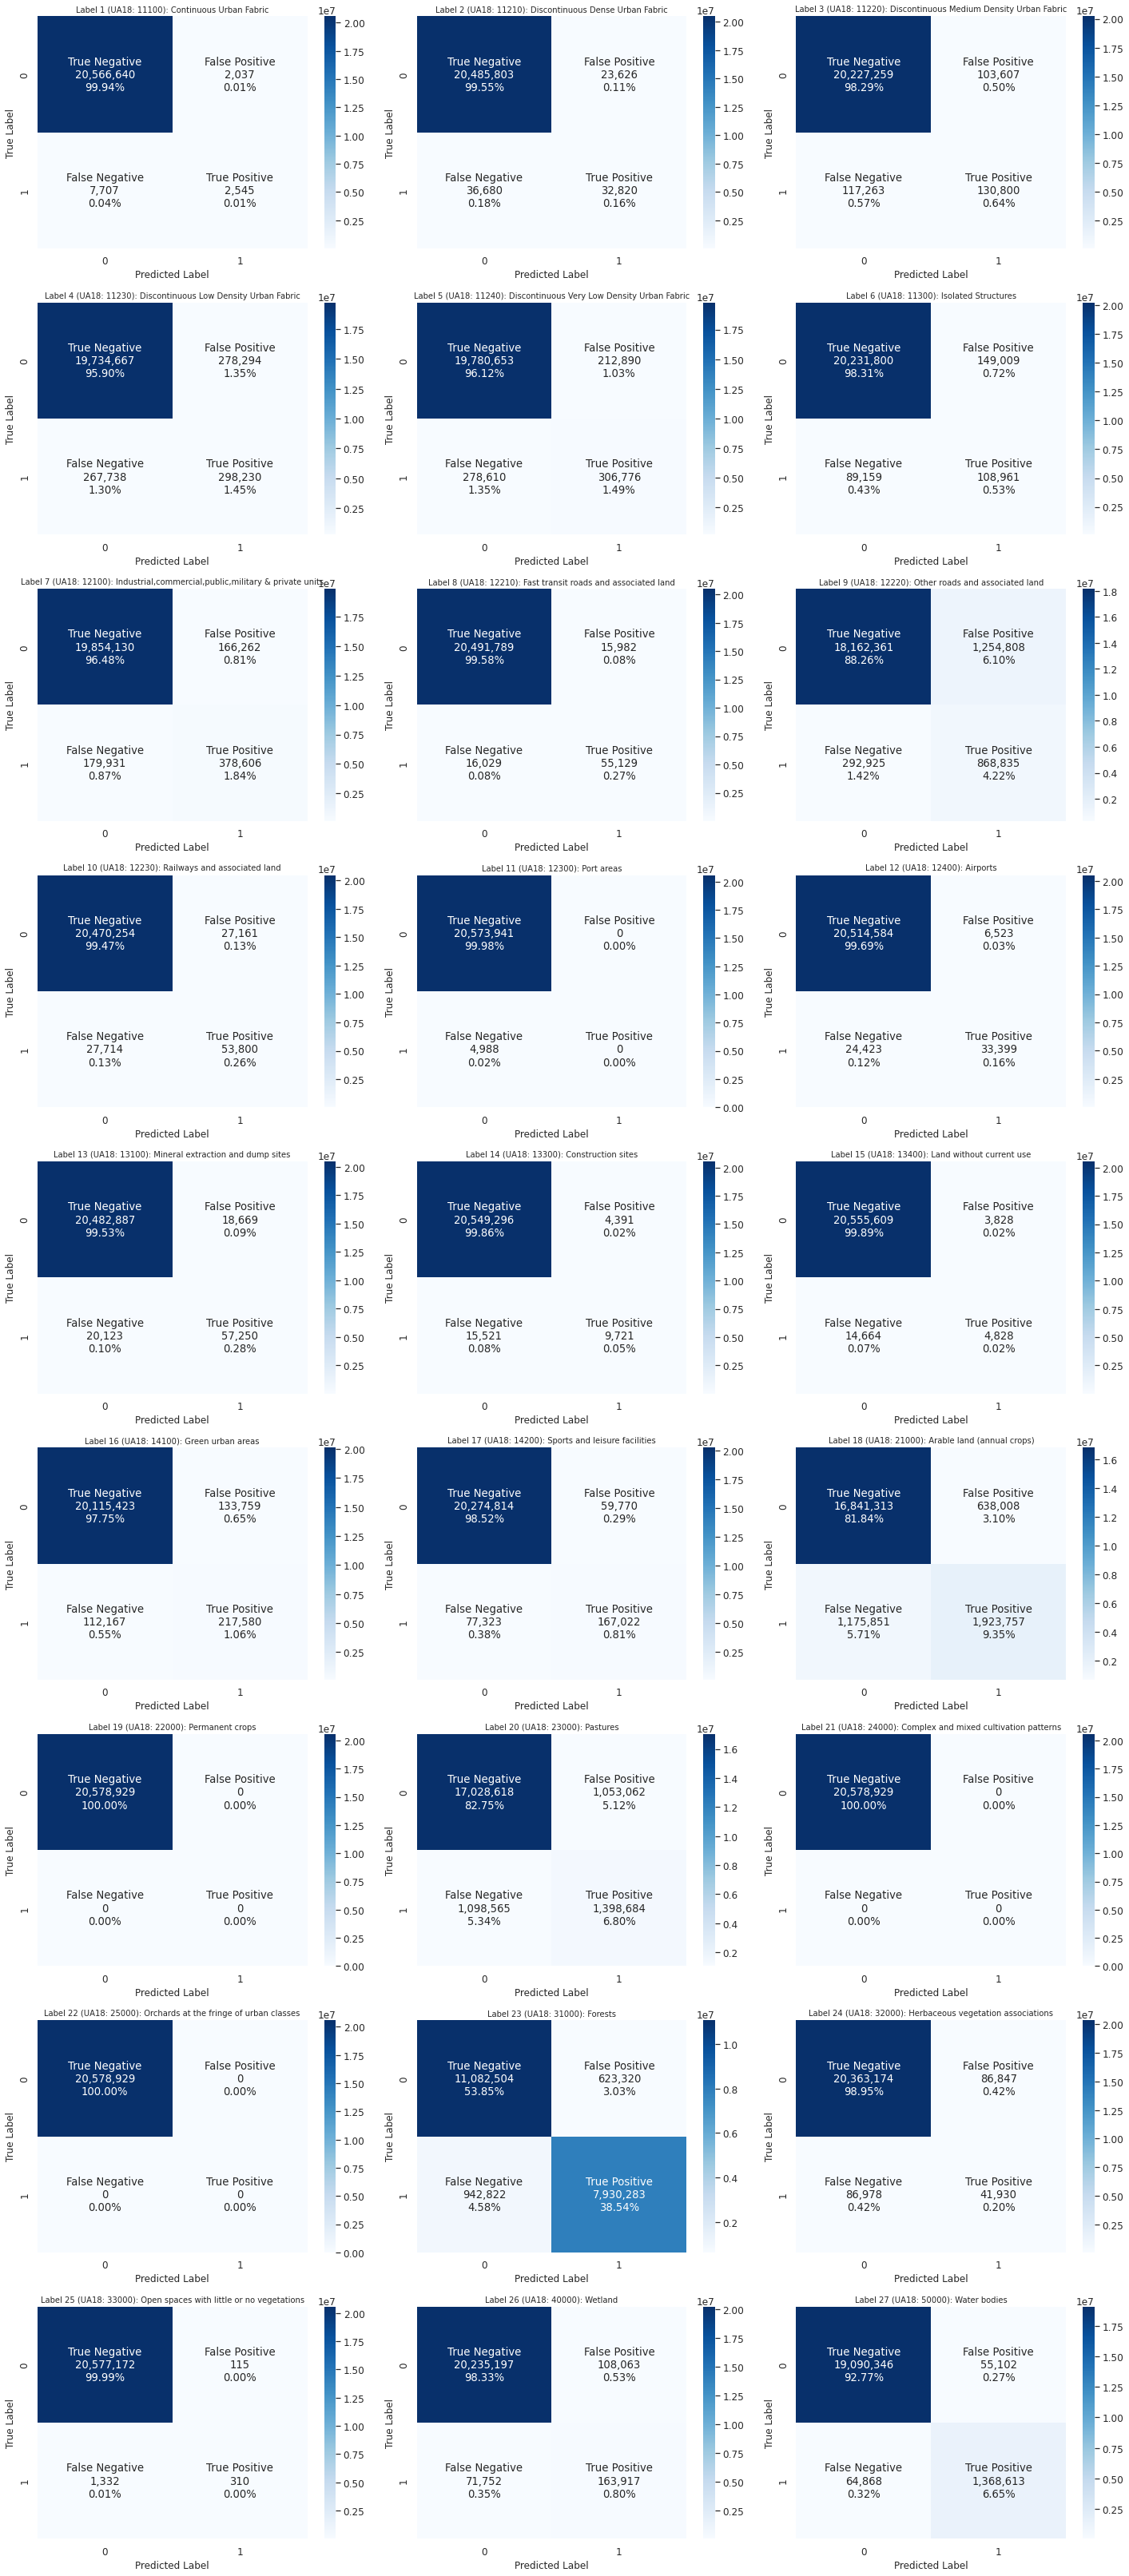

In [37]:
# Plot Confusion Matrices
plotConfusionMatrices(cMats)

In [21]:
# Print model metrics to TENSORBOARD. Default path = 'runs/'
printModelMetrics(model_metrics,TB=True)

In [22]:
# Print class metrics to TENSORBOARD. Default path = 'runs/'
printClassMetrics(class_metrics,classCounts,TB=True)

/home/exjobbare/projects/datadrive0/deepSat/train/metrics.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataRow = pd.DataFrame({'Label':[l+1], 'UA2018 ID':ua, '% Data':[p.item()], 'Accuracy':[acc], 'Precision':[prc],
/home/exjobbare/projects/datadrive0/deepSat/train/metrics.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataRow = pd.DataFrame({'Label':[l+1], 'UA2018 ID':ua, '% Data':[p.item()], 'Accuracy':[acc], 'Precision':[prc],
/home/exjobbare/projects/datadrive0/deepSat/train/metrics.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataRow = pd.DataFrame({'Label':[l+1], 'UA2018 ID':ua, '% Data':[p.item()], 'Accuracy':[acc], 'Precision':[prc],
/home/exjobbare/projects/datadrive0/deepSat/train/metrics.

In [23]:
# Plot N_CLASS X N_CLASS confusion matrix to TENSORBOARD. Default path = 'runs/'
plotConfusionMatrix(yTrue=labelarr,yPred=predarr,TB=True)

In [24]:
# Plot confusion matrices to TENSORBOARD. Default path = 'runs/'
plotConfusionMatrices(cMats,TB=True)